In [8]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
import pandas_ta as ta

# FUNCTION TO CREATE 1D DATA INTO TIME SERIES DATASET
# THIS FUNCTION CAN BE USED TO CREATE A TIME SERIES DATASET FROM ANY 1D ARRAY
def new_dataset(dataset,ta_ind, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:(i+step_size), :]
		a = np.concatenate((a,ta_ind[i:(i+step_size), :]), axis=-1)
		data_X.append(a)
		data_Y.append(dataset[i + step_size, :])
	return np.array(data_X), np.array(data_Y)


In [9]:
# FOR REPRODUCIBILITY
np.random.seed(7)

# IMPORTING DATASET
dataset = pd.read_csv('apple_share_price.csv', usecols=[1, 2, 3, 4])
df = dataset.ta.macd()
df.fillna(0,inplace=True)
df=df.reindex(index=df.index[::-1])
dataset = dataset.reindex(index=dataset.index[::-1])
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis=1)
HLC_avg = dataset[['high', 'low', 'close']].mean(axis=1)
close_val = dataset[['close']]
# PLOTTING ALL INDICATORS IN ONE PLOT
# plt.plot(obs, OHLC_avg, 'r', label='OHLC avg')
# plt.plot(obs, HLC_avg, 'b', label='HLC avg')
# plt.plot(obs, close_val, 'g', label='Closing price')
# plt.legend(loc='upper right')
# plt.show()


In [10]:
# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg), 1))  # 1664
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)
scaler_ta=MinMaxScaler(feature_range=(0,1))
df_ta=scaler_ta.fit_transform(df)
# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.75)
x=int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,
                                 :], OHLC_avg[train_OHLC:len(OHLC_avg), :]
train_ta, test_ta = df_ta[0:x, :], df_ta[x:len(OHLC_avg),:]
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_OHLC,train_ta, 1)
testX, testY = new_dataset(test_OHLC,test_ta, 1)
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[2], trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[2], testX.shape[1]))
step_size = 1
testY=np.reshape(testY,(-1))
trainY = np.reshape(trainY, (-1))


In [11]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(4, step_size), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

# MODEL COMPILING AND TRAINING
# Try SGD, adam, adagrad and compare!!!
model.compile(loss='mean_squared_error', optimizer='adagrad')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Epoch 1/5


Train RMSE: 4.93
Test RMSE: 11.74


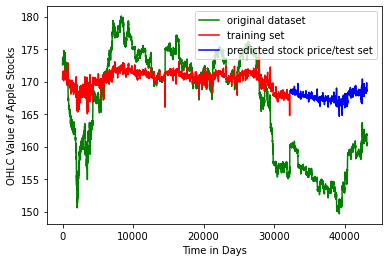

Last Day Value: 168.53030395507812
Next Day Value: 35.1496467590332


<ipython-input-137-88e8e92683cb>:36: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print("Last Day Value:", np.asscalar(last_val))
<ipython-input-137-88e8e92683cb>:37: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print("Next Day Value:", np.asscalar(last_val*next_val))


In [ ]:
# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))

# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print(trainScore, testScore)
